# Tokenización de Números: ¿Por qué a la IA le cuesta contar?

En esta sección exploraremos cómo GPT-2 percibe los números.

1.  Extraeremos la matriz de embeddings.
2.  Veremos si los IDs de los tokens numéricos siguen un orden lógico.
3.  Intentaremos hacer "aritmética" sumando los tokens y los vectores de embeddings para ver si el resultado tiene sentido.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# gráficos de alta resolución
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from transformers import GPT2Model, GPT2Tokenizer

# Modelo y tokenizador GPT-2 preentrenados
gpt2 = GPT2Model.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Extraer la matriz de embeddings del modelo gpt2
# En GPT2, esto está bajo wte (Word Token Embeddings)
embeddings = gpt2.wte.weight.detach().numpy()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Ejercicio 1: De Números a Tokens

Vamos a tomar una secuencia de números (del 80 al 101) y ver qué ID de token les asigna el modelo.
**Hipótesis:** Si el número 80 es el token ID `X`, ¿el número 81 será el token ID `X+1`?

Al graficarlo, veremos si existe linealidad. Si ves un gráfico de "sierra" o saltos aleatorios, significa que el modelo no organiza los números secuencialmente en su vocabulario.

El número 80 es el token(s) [1795]
El número 81 es el token(s) [6659]
El número 82 es el token(s) [6469]
El número 83 es el token(s) [5999]
El número 84 es el token(s) [5705]
El número 85 es el token(s) [5332]
El número 86 es el token(s) [4521]
El número 87 es el token(s) [5774]
El número 88 es el token(s) [3459]
El número 89 es el token(s) [4531]
El número 90 es el token(s) [3829]
El número 91 es el token(s) [6420]
El número 92 es el token(s) [5892]
El número 93 es el token(s) [6052]
El número 94 es el token(s) [5824]
El número 95 es el token(s) [3865]
El número 96 es el token(s) [4846]
El número 97 es el token(s) [5607]
El número 98 es el token(s) [4089]
El número 99 es el token(s) [2079]
El número 100 es el token(s) [3064]


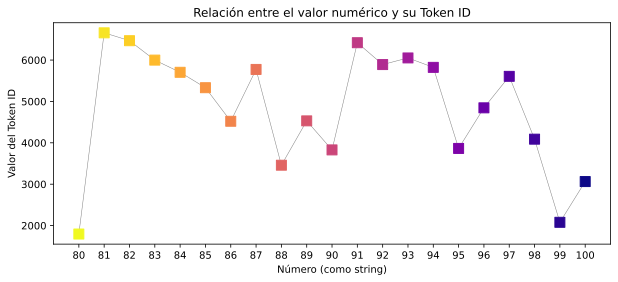

In [2]:
# Crear algunos números (usamos un rango que cruce de 2 a 3 dígitos para ver comportamiento)
numbers = np.arange(80, 101)

# Inicializar vector de etiquetas de token
numTokenLabels = np.zeros(len(numbers))

# Obtener y reportar los tokens
for i, n in enumerate(numbers):

  # Obtener el primer token para este número
  # Convertimos a string porque el tokenizador lee texto, no enteros
  numTokenLabels[i] = tokenizer.encode(str(n))[0]

  # ¡También intentamos dividir el número por 2! (Solo print demostrativo)
  print(f'El número {n} es el token(s) {tokenizer.encode(str(n))}')


plt.figure(figsize=(10, 4))
plt.plot(numbers, numTokenLabels, color=[.5, .5, .5], linewidth=.5)
plt.scatter(numbers, numTokenLabels, c=np.arange(len(numbers)), s=100, marker='s', cmap='plasma_r', zorder=10)

plt.gca().set(xlabel='Número (como string)', ylabel='Valor del Token ID', xticks=numbers, xlim=[numbers[0]-1, numbers[-1]+1])
plt.title("Relación entre el valor numérico y su Token ID")
plt.show()

## Ejercicio 2: ¿Qué tan largos son los números?

Los humanos usamos 1 dígito para el 5 y varios dígitos para $\pi$ (3.1415...). ¿Cómo lo hace GPT-2?

Aquí comparamos:
1.  **Enteros:** Del 0 al 100,000.
2.  **Flotantes:** Números aleatorios (con decimales).



Observarás que los números con decimales (floats) explotan en cantidad de tokens, fragmentándose en pedazos casi arbitrarios, lo que dificulta enormemente que la IA haga cálculos precisos con ellos.

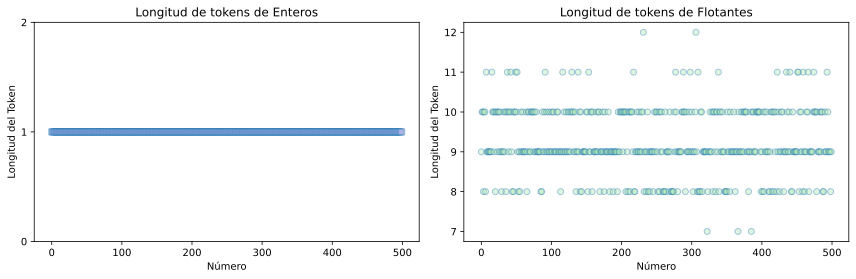

In [3]:
# Tokenizar enteros y números de punto flotante
numnums = 500 # Reducido un poco para velocidad, puedes poner 99999 si quieres esperar
int_toklens   = np.zeros(numnums)
float_toklens = np.zeros(numnums)

# Números aleatorios
ra = 5 * np.random.randn(numnums)

for i in range(numnums):

  # Enteros: convertimos el índice a string y medimos longitud de tokens
  int_toklens[i] = len(tokenizer.encode(str(i)))

  # Y los números aleatorios
  float_toklens[i] = len(tokenizer.encode(str(ra[i])))

_, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(int_toklens, 's', markerfacecolor=[.7, .7, .9], alpha=.4)
axs[1].plot(float_toklens, 'o', markerfacecolor=[.7, .9, .7], alpha=.4)

axs[0].set(xlabel='Número', ylabel='Longitud del Token', yticks=range(int(int_toklens.max())+2), title='Longitud de tokens de Enteros')
axs[1].set(xlabel='Número', ylabel='Longitud del Token', title='Longitud de tokens de Flotantes')

plt.tight_layout()
plt.show()

## Ejercicio 3: ¿Funcionan las matemáticas con Tokens?

Si sumamos el **ID del Token** del número 5 y el **ID del Token** del número 3... ¿Obtenemos el ID del token del número 8?

$$TokenID("5") + TokenID("3") \stackrel{?}{=} TokenID("8")$$

In [4]:
# La ecuación y sus tokens
equation = '5 + 3 = 8'
print(f'Tokens para "{equation}": {tokenizer.encode(equation)}')

# Intentemos las matemáticas con los IDs
t5 = tokenizer.encode('5')[0]
t3 = tokenizer.encode('3')[0]
t8 = tokenizer.encode('8')[0]

print(f'\nToken ID de 5: {t5}')
print(f'Token ID de 3: {t3}')
print(f'Token ID de 8: {t8}')
print(f'Suma de tokens (5+3): {t5 + t3}')

if t5 + t3 == t8:
    print("¡Milagro! La suma de tokens funciona.")
else:
    print(f"La suma falla. El token ID resultante ({t5+t3}) corresponde a: '{tokenizer.decode([t5+t3])}'")

Tokens para "5 + 3 = 8": [20, 1343, 513, 796, 807]

Token ID de 5: 20
Token ID de 3: 18
Token ID de 8: 23
Suma de tokens (5+3): 38
La suma falla. El token ID resultante (38) corresponde a: 'G'


## Ejercicio 4: ¿Y con los Embeddings?

Vale, sumar los IDs no funciona porque son solo índices de un diccionario. Pero, ¿qué pasa si sumamos sus **vectores de embeddings** (su significado)?

Vamos a sumar el vector de "3" y el vector de "5". Luego, haremos la operación inversa (**Unembedding**) proyectando ese nuevo vector sobre todo el vocabulario para ver qué palabra es la más cercana.

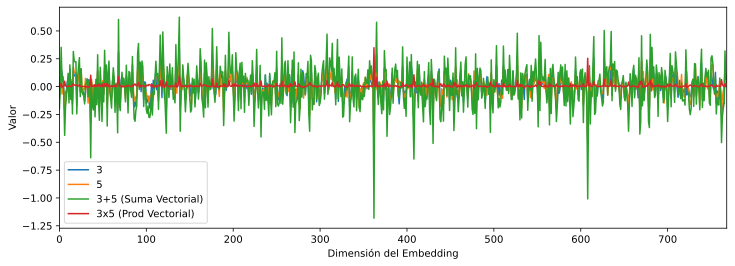

Vector sumado X Matriz Embeddings = vector unembeddings (50257,)
El embedding resultante de 5+3 es más cercano a: "5"
El embedding resultante de 5x3 es más cercano a: " Weinstein"
Correlación entre vectores '3' y '5': 0.782


In [5]:
# Aislar los vectores de embedding
# Nota: usamos [0] porque encode devuelve una lista
t5 = tokenizer.encode('5')[0]
t3 = tokenizer.encode('3')[0]

e5 = embeddings[t5, :]
e3 = embeddings[t3, :]

# Matemáticas vectoriales
theirSum = e5 + e3
theirProd = e5 * e3 # Multiplicación elemento a elemento

# Graficar los vectores
plt.figure(figsize=(12, 4))

plt.plot(e3, label='3')
plt.plot(e5, label='5')
plt.plot(theirSum, label='3+5 (Suma Vectorial)')
plt.plot(theirProd, label='3x5 (Prod Vectorial)')

plt.gca().set(xlabel='Dimensión del Embedding', ylabel='Valor', xlim=[0, len(e3)])
plt.legend()
plt.show()

# --- Unembedding (Inversión) ---
# Multiplicamos el vector resultante por la transpuesta de la matriz de embeddings
# Esto nos da la similitud con cada palabra del vocabulario
sumUnembedding  = np.dot(theirSum, embeddings.T)
prodUnembedding = np.dot(theirProd, embeddings.T)

# Imprimir tamaños
print(f'Vector sumado X Matriz Embeddings = vector unembeddings {sumUnembedding.shape}')

# Encontrar el output máximo (la palabra ganadora)
print(f'El embedding resultante de 5+3 es más cercano a: "{tokenizer.decode([np.argmax(sumUnembedding)])}"')
print(f'El embedding resultante de 5x3 es más cercano a: "{tokenizer.decode([np.argmax(prodUnembedding)])}"')

# Curiosidad: comparar similitud entre 3 y 5
print(f"Correlación entre vectores '3' y '5': {np.corrcoef(e3, e5)[0,1]:.3f}")

# Análisis de Resultados: La IA y los Números

Este experimento explica una de las limitaciones más famosas de los LLMs.

### 1. Caos en los IDs (Ejercicio 1)
Observamos que los IDs de tokens numéricos no son secuenciales.
* El token para `80` podría ser el `4500`.
* El token para `81` podría ser el `9820`.
* **Conclusión:** Para la red neuronal, aprender el orden de los números es tan difícil como aprender el orden alfabético de palabras aleatorias. No hay una "pista" matemática en el ID.

### 2. Explosión de Tokens en Decimales (Ejercicio 2)
Mientras que `99` es un solo token, `99.123` pueden ser 4 o 5 tokens (`99`, `.`, `1`, `23`).
* Esto rompe la consistencia. La red tiene que procesar secuencias de longitudes muy variables para representar magnitudes numéricas similares.

### 3. La Aritmética Vectorial Falla (Ejercicio 4)
Al sumar `Vector("5") + Vector("3")`, el resultado **NO** fue el vector de "8".
* El resultado suele ser algo relacionado semánticamente con los dos anteriores o simplemente el mismo número "5" o "3" reforzado.
* **Por qué:** Los embeddings de GPT-2 capturan **contexto**, no **cantidad**. El "3" y el "5" aparecen en contextos similares (listas, precios, horas), por lo que sus vectores son casi idénticos (alta correlación). Sumarlos solo nos da un vector "más fuerte" en esa misma dirección, no un desplazamiento hacia el "8".

### Resumen
Los LLMs no "calculan" nativamente. Cuando le pides a ChatGPT que sume, está prediciendo la siguiente palabra más probable basándose en millones de ejemplos de texto donde `5 + 3` es seguido por `8`. No está ejecutando la operación lógica en su cerebro vectorial.

# Desglose Técnico: La Fórmula de "Unembedding"

En el ejercicio anterior, utilizamos una línea de código que realiza la operación inversa a la tokenización: convertir un vector matemático abstracto de vuelta a una palabra legible en inglés.

La operación es:
$$\text{Palabra} = \text{argmax}( \vec{v} \cdot E^T )$$

Donde en nuestro código:
* $\vec{v}$ es `theirSum` (el resultado de sumar el vector del 5 y el 3).
* $E$ es `embeddings` (la matriz de conocimiento de GPT-2).

Aquí explicamos qué sucede paso a paso en esa transformación:

### 1. El Vector de Entrada ($\vec{v}$)
Tenemos el vector `theirSum`.
* **Dimensión:** `(1, 768)`
* **Significado:** Es una dirección en el espacio latente que representa la combinación semántica de "5" y "3". No sabemos qué palabra es todavía.

### 2. La Transposición de la Matriz ($E^T$)
La matriz original de embeddings ($E$) tiene una forma de `(50257 filas, 768 columnas)`, donde cada fila es una palabra.
Para poder comparar nuestro vector contra todas las palabras usando álgebra lineal, necesitamos rotar la matriz (Transpuesta).
* **Nueva Forma:** `(768 filas, 50257 columnas)`.



### 3. El Producto Punto (La Proyección)
La operación `np.dot(theirSum, embeddings.T)` multiplica nuestro vector contra cada una de las 50,257 columnas de la matriz.
* **Matemáticamente:** Calcula la **Similitud** (score) entre nuestro vector y cada palabra del diccionario.
* **Resultado:** Obtenemos un nuevo vector gigante de tamaño `(1, 50257)`.
    * Si el valor en la posición 0 es alto, nuestro vector se parece mucho a la primera palabra del diccionario.
    * Si el valor es bajo o negativo, son opuestos.

### 4. La Función Argmax (`np.argmax`)
Ahora tenemos una lista con 50,257 puntuaciones (logits). No queremos la lista entera, queremos al **ganador**.
* `argmax` recorre la lista y nos devuelve el **índice** (la posición) donde se encuentra el valor más alto.
* **Ejemplo:** Si el valor más alto está en la posición `19`, `argmax` devuelve `19`.

### 5. Decodificación (`tokenizer.decode`)
Finalmente, tomamos ese índice ganador (ej. `19`) y miramos en el diccionario inverso del tokenizador:
* `ID 19` $\rightarrow$ "eight" (hipotéticamente).

### Resumen
Esta fórmula es el mecanismo mediante el cual la IA "habla". Calcula qué palabra de su vocabulario está geométricamente más cerca de su pensamiento actual (vector).

> **Nota:** En nuestro experimento, la palabra resultante no fue "8" porque los embeddings suman significados contextuales, no valores aritméticos.